## Mounting Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


##Loading VGG16 model

In [2]:
from keras.applications import MobileNet
conv_base = MobileNet(weights= 'imagenet', include_top= False, input_shape= (150, 150, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 0s 0us/step


##Architecture of VGG16

In [3]:
conv_base.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 151, 151, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 75, 75, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 75, 75, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 75, 75, 32) 

##Building the model

In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation= 'relu'))
model.add(layers.Dense(256, activation= 'relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              16778240  
_________________________________________________________________
dense_5 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 1285      
Total params: 20,270,789
Trainable params: 20,248,901
Non-trainable params: 21,888
_________________________________________________________________


##Data Preprocessing for Training and Testing

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import os
import numpy as np

base_dir = r'gdrive/My Drive/face_shape_one'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

rescale_factor = 1./255

train_datagen = ImageDataGenerator(rescale= rescale_factor,
                                  width_shift_range= 40,
                                  height_shift_range= 0.2,
                                  shear_range= 0.2,
                                  zoom_range= 0.2,
                                  horizontal_flip= True,
                                  fill_mode= 'nearest')

test_datagen = ImageDataGenerator(rescale= rescale_factor)

target_width = 150
target_height = 150

train_sample_size = 400
train_batch_size = 20

valid_sample_size = 50
valid_batch_size = 10

test_sample_size = 50
test_batch_size = 10

train_generator = train_datagen.flow_from_directory(
                                directory= train_dir, 
                                target_size= (target_width, target_height),
                                batch_size= train_batch_size, 
                                class_mode= 'categorical')


validation_generator = test_datagen.flow_from_directory(
                                directory= validation_dir, 
                                target_size= (target_width, target_height), 
                                batch_size= valid_batch_size,
                                class_mode= 'categorical')

test_generator = test_datagen.flow_from_directory(
                                directory= test_dir, 
                                target_size= (target_width, target_height), 
                                batch_size= test_batch_size,
                                class_mode= 'categorical')


Found 400 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


##Freeze Conv Base before training


In [0]:
conv_base.trainable = False

##Compile the learning environment

In [0]:
model.compile(loss= 'categorical_crossentropy', 
              optimizer= optimizers.RMSprop(learning_rate=2e-5),
              metrics= ['acc'])

##Training end-to-end on Frozen layers

In [9]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

history = model.fit_generator(
                    generator= train_generator,
                    steps_per_epoch= STEP_SIZE_TRAIN, 
                    epochs= 30, 
                    validation_data= validation_generator, 
                    validation_steps= STEP_SIZE_VALID)

Epoch 1/30
20/20 [==============================] - 107s 5s/step - loss: 2.1359 - acc: 0.2225 - val_loss: 1.3835 - val_acc: 0.2800
Epoch 2/30
20/20 [==============================] - 18s 885ms/step - loss: 1.7091 - acc: 0.3250 - val_loss: 1.7087 - val_acc: 0.3200
Epoch 3/30
20/20 [==============================] - 18s 884ms/step - loss: 1.4624 - acc: 0.4575 - val_loss: 1.6706 - val_acc: 0.3400
Epoch 4/30
20/20 [==============================] - 18s 880ms/step - loss: 1.4256 - acc: 0.4400 - val_loss: 1.6434 - val_acc: 0.2800
Epoch 5/30
20/20 [==============================] - 18s 894ms/step - loss: 1.2665 - acc: 0.4700 - val_loss: 1.6297 - val_acc: 0.3400
Epoch 6/30
20/20 [==============================] - 18s 895ms/step - loss: 1.2732 - acc: 0.4775 - val_loss: 1.6426 - val_acc: 0.3400
Epoch 7/30
20/20 [==============================] - 18s 885ms/step - loss: 1.1696 - acc: 0.5425 - val_loss: 1.8432 - val_acc: 0.3200
Epoch 8/30
20/20 [==============================] - 18s 895ms/step - lo

**Plotting the result**

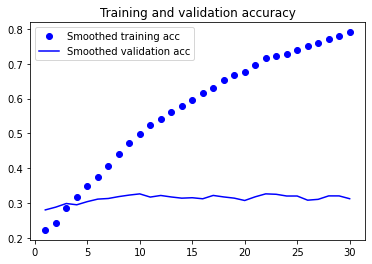

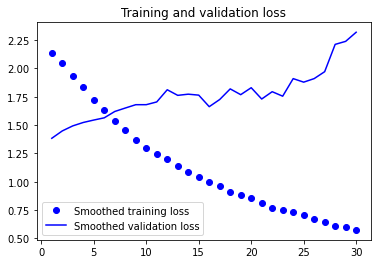

In [10]:
import matplotlib.pyplot as plt

# Plotting the results with smooth curve
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
       
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
           
        else:
            smoothed_points.append(point)
    return smoothed_points

def plot_result(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc)+1)
  plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
  plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
  plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
  plt.title('Training and validation loss') 
  plt.legend()
  plt.show()

plot_result(history)

#Fine-Tuning the model 
## Freeze all layers except the last four


In [0]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'conv_pw_12':
    set_trainable = True

  if set_trainable:
    layer.trainable = True

  else:
    layer.trainable = False

##Recompile the model

In [0]:
model.compile(loss= 'categorical_crossentropy', 
              optimizer= optimizers.RMSprop(learning_rate=1e-5),
              metrics= ['acc'])

##Retrain the model

In [13]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

history = model.fit_generator(
                    generator= train_generator,
                    steps_per_epoch= STEP_SIZE_TRAIN, 
                    epochs= 28, 
                    validation_data= validation_generator, 
                    validation_steps= STEP_SIZE_VALID)

Epoch 1/28
20/20 [==============================] - 24s 1s/step - loss: 0.4767 - acc: 0.8200 - val_loss: 1.9769 - val_acc: 0.3200
Epoch 2/28
20/20 [==============================] - 20s 1s/step - loss: 0.4309 - acc: 0.8500 - val_loss: 1.7048 - val_acc: 0.3200
Epoch 3/28
20/20 [==============================] - 21s 1s/step - loss: 0.4254 - acc: 0.8675 - val_loss: 2.4597 - val_acc: 0.4000
Epoch 4/28
20/20 [==============================] - 21s 1s/step - loss: 0.4550 - acc: 0.8275 - val_loss: 2.8862 - val_acc: 0.3800
Epoch 5/28
20/20 [==============================] - 21s 1s/step - loss: 0.4530 - acc: 0.8350 - val_loss: 2.3109 - val_acc: 0.4000
Epoch 6/28
20/20 [==============================] - 21s 1s/step - loss: 0.3985 - acc: 0.8525 - val_loss: 1.8203 - val_acc: 0.4400
Epoch 7/28
20/20 [==============================] - 21s 1s/step - loss: 0.3772 - acc: 0.8800 - val_loss: 2.0991 - val_acc: 0.4400
Epoch 8/28
20/20 [==============================] - 21s 1s/step - loss: 0.3862 - acc: 0.86

##Plotting the results

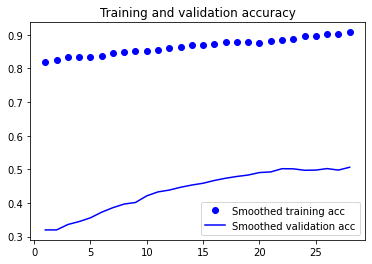

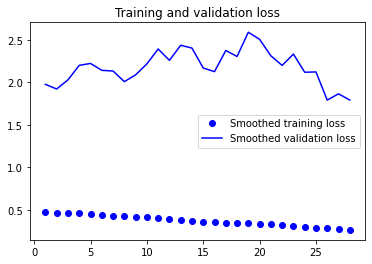

In [14]:
plot_result(history)

**Evaluating the model on test dataset**

In [0]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

test_loss, test_acc = model.evaluate_generator(test_generator, STEP_SIZE_TEST)


In [16]:
print('Accuracy on the dataset: ', test_acc*100, '%')

Accuracy on the dataset:  41.999998688697815 %


In [0]:
model.save('mobileNet_aug_face_shape_one.h5')